# Image Classification Batch Inference with Huggingface Vision Transformer

In this example, we will introduce how to use the [Ray Data](data) for **large-scale image classification batch inference with multiple GPU workers.**

In particular, we will:
- Load Imagenette dataset from S3 bucket and create a {class}`Ray Dataset <ray.data.dataset.Dataset>`.
- Load a pretrained Vision Transformer from Huggingface that's been trained on ImageNet.
- Use [Ray Data](data) to preprocess the dataset and do model inference parallelizing across multiple GPUs
- Evaluate the predictions and save results to S3/local disk.

This example will still work even if you do not have GPUs available, but overall performance will be slower.

To run this example, you will need to install the following:

In [1]:
!pip install -q -U "ray[data]" transformers

## Step 1: Reading the Dataset from S3

[Imagenette](https://github.com/fastai/imagenette) is a subset of Imagenet with 10 classes. We have this dataset hosted publicly in an S3 bucket. Since we are only doing inference here, we load in just the validation split.

Here, we use {meth}`ray.data.read_images <ray.data.read_images>` to load the validation set from S3. [Ray Data](data) also supports reading from a variety of other [datasources and formats](loading_data).

In [1]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/val/"

ds = ray.data.read_images(
    s3_uri, mode="RGB"
)
ds


2023-10-03 15:06:36,125	INFO worker.py:1489 -- Connecting to existing Ray cluster at address: 10.0.28.79:6379...
2023-10-03 15:06:36,133	INFO worker.py:1664 -- Connected to Ray cluster. View the dashboard at https://session-l4m8w2hmif7kg1kqdu4j4r8u19.i.anyscaleuserdata.com 
2023-10-03 15:06:36,155	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_297c3d2ea3dd8d3d373993b7f9ea82c4.zip' (6.81MiB) to Ray cluster...
2023-10-03 15:06:36,182	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_297c3d2ea3dd8d3d373993b7f9ea82c4.zip'.


Dataset(
   num_blocks=200,
   num_rows=3925,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

Inspecting the schema, we can see that there is 1 column in the dataset containing the images stored as Numpy arrays.

In [2]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

## Step 2: Inference on a single batch

Next, we can do inference on a single batch of data, using a pre-trained Vision Transformer from Huggingface following [this Huggingface example](https://huggingface.co/docs/transformers/tasks/image_classification#inference). 

Let’s get a batch of 10 from our dataset. Each image in the batch is represented as a Numpy array.

In [3]:
single_batch = ds.take_batch(10)

2023-10-03 15:06:39,698	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]
2023-10-03 15:06:39,699	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-03 15:06:39,700	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

We can visualize 1 image from this batch.

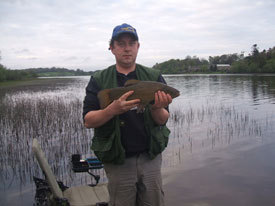

In [4]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

Now, let’s create a Huggingface Image Classification pipeline from a pre-trained Vision Transformer model.

We specify the following configurations:
1. Set the device to "cuda:0" to use GPU for inference
2. We set the batch size to 10 so that we can maximize GPU utilization and do inference on the entire batch at once. 

We also convert the image Numpy arrays into PIL Images since that's what Huggingface expects.

From the results, we see that all of the images in the batch are correctly being classified as "tench" which is a type of fish.

In [5]:
from transformers import pipeline
from PIL import Image

# Note, you must have GPUs on your head node in order to do this with GPUs.
# If doing CPU inference, set device="cpu" instead.
classifier = pipeline("image-classification", model="google/vit-base-patch16-224", device="cuda:0")
outputs = classifier([Image.fromarray(image_array) for image_array in single_batch["image"]], top_k=1, batch_size=10)
del classifier # Delete the classifier to free up GPU memory.
outputs

[[{'score': 0.9997267127037048, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9993537068367004, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9997393488883972, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.99950110912323, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9986729621887207, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.999290943145752, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9997896552085876, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9997585415840149, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9985774755477905, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9996065497398376, 'label': 'tench, Tinca tinca'}]]

## Step 3: Scaling up to the full Dataset with Ray Data

By using Ray Data, we can apply the same logic in the previous section to scale up to the entire dataset, leveraging all the GPUs in our cluster.

There are a couple unique properties about the inference step:
1. Model initialization is usually pretty expensive
2. We want to do inference in batches to maximize GPU utilization.


To address 1, we package the inference code in a `ImageClassifier` class. Using a class allows us to put the expensive pipeline loading and initialization code in the `__init__` constructor, which will run only once. 
The actual model inference logic is in the `__call__` method, which will be called for each batch.

To address 2, we do our inference in batches, specifying a `batch_size` to the Huggingface Pipeline.
The `__call__` method takes a batch of data items, instead of a single one. 
In this case, the batch is a dict that has one key named "image", and the value is a Numpy array of images represented in `np.ndarray` format. This is the same format in step 2, and we can reuse the same inferencing logic from step 2.

In [8]:
from typing import Dict
import numpy as np

from transformers import pipeline
from PIL import Image

# Pick the largest batch size that can fit on our GPUs
BATCH_SIZE = 1024

class ImageClassifier:
    def __init__(self):
        # If doing CPU inference, set `device="cpu"` instead.
        self.classifier = pipeline("image-classification", model="google/vit-base-patch16-224", device="cuda:0")

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a list of PIL images which is the format the HF pipeline expects.
        outputs = self.classifier(
            [Image.fromarray(image_array) for image_array in batch["image"]], 
            top_k=1, 
            batch_size=BATCH_SIZE)
        
        # `outputs` is a list of length-one lists. For example:
        # [[{'score': '...', 'label': '...'}], ..., [{'score': '...', 'label': '...'}]]
        batch["score"] = [output[0]["score"] for output in outputs]
        batch["label"] = [output[0]["label"] for output in outputs]
        return batch

Then we use the {meth}`map_batches <ray.data.Dataset.map_batches>` API to apply the model to the whole dataset. 

The first parameter of `map_batches` is the user-defined function (UDF), which can either be a function or a class. Since we are using a class in this case, the UDF will run as long-running [Ray actors](https://docs.ray.io/en/latest/ray-core/key-concepts.html#actors). For class-based UDFs, we use the `compute` argument to specify {class}`ActorPoolStrategy <ray.data.dataset_internal.compute.ActorPoolStrategy>` with the number of parallel actors. And the `batch_size` argument indicates the number of images in each batch.

The `num_gpus` argument specifies the number of GPUs needed for each `ImageClassifier` instance. In this case, we want 1 GPU for each model replica.

In [12]:
predictions = ds.map_batches(
    ImageClassifier,
    compute=ray.data.ActorPoolStrategy(size=4), # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica.
    batch_size=BATCH_SIZE # Use the largest batch size that can fit on our GPUs
)

### Verify and Save Results

Let's take a small batch and verify the results.

In [13]:
prediction_batch = predictions.take_batch(5)

[2023-05-24 12:08:44] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> ActorPoolMapOperator[MapBatches(ImageClassifier)]
[2023-05-24 12:08:44] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
[2023-05-24 12:08:44] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
[2023-05-24 12:08:44] [Ray Data] INFO ray.data._internal.execution.operators.actor_pool_map_operator.logfile::MapBatches(ImageClassifier): Waiting for 4 pool actors to start...
(_MapWorker pid=137172) 2023-05-24 12:08:49.035713: W tensorflow/compiler

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

[2023-05-24 12:09:22] [Ray Data] INFO ray.data._internal.execution.streaming_executor.logfile::Shutting down <StreamingExecutor(Thread-759, started daemon 140117905766144)>.
[2023-05-24 12:09:22] [Ray Data] WARNING ray.data._internal.execution.operators.actor_pool_map_operator.logfile::To ensure full parallelization across an actor pool of size 4, the specified batch size should be at most 255. Your configured batch size for this operator was 1024.


We see that all 5 of the images are correctly classified as "tench", which is a type of fish. (You may need to scroll to see all of the samples below.)

Image:


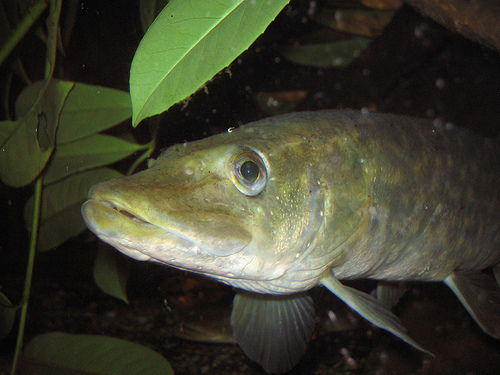

Label:  tench, Tinca tinca
Image:


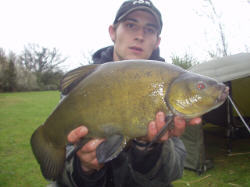

Label:  tench, Tinca tinca
Image:


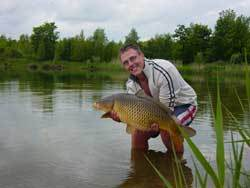

Label:  tench, Tinca tinca
Image:


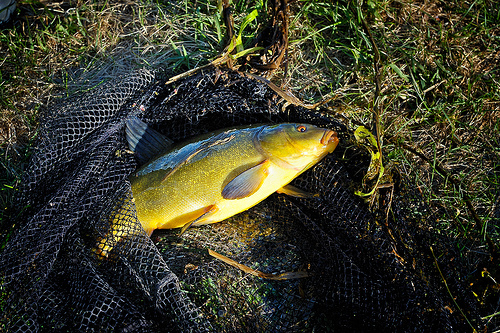

Label:  tench, Tinca tinca
Image:


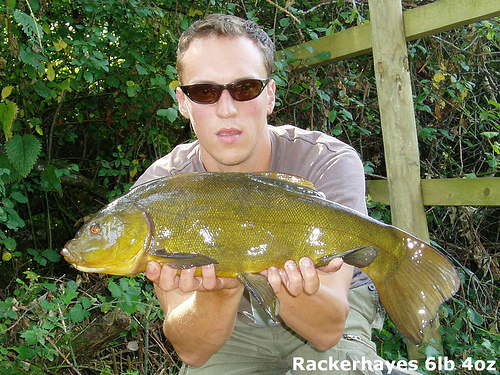

Label:  tench, Tinca tinca
Successfully displayed 5 images.


In [16]:
from PIL import Image
from IPython.display import display


img_count = 0
for image, prediction in zip(prediction_batch["image"], prediction_batch["label"]):
    img = Image.fromarray(image)
    print("Image:")
    # Use Jupyter to display the image inline.
    display(img)
    print("Label: ", prediction)
    img_count += 1
print("Successfully displayed {} images.".format(img_count))

If the samples look good, we can proceed with saving the results to an external storage, e.g., S3 or local disks. See [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html) for all supported stoarges and file formats.

```python
ds.write_parquet("local://tmp/inference_results")
```